# Analiza danych hydrologicznych - stacja Kraków-Czernichów, 2016-2018

## Zaimportowane moduły i pliki

In [1]:
import time
import zipfile
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_dir = 'dane.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_hydrologiczne/dobowe'
zip_files = glob(f'{data_dir}/*/*.zip')

## Ekstrakcja z archiwów .zip
Ten skrypt ma za zadanie wypakowanie zawartości pliku .zip (plik .csv) do tej samej ścieżki, a następnie stworzenie listy otrzymanych plików .csv.

In [3]:
def unpack(files: list) -> list:
    for file in files:
        with zipfile.ZipFile(file) as zip_file:
            zip_file.extractall(file[:77])

    #csv files - new list
    csv_files = glob(f'{data_dir}/*/*.csv')

    return sorted(csv_files)



## Analiza danych

In [4]:
start_time = time.time()
codz_names = (
    'Kod stacji',
    'Nazwa stacji',
    'Nazwa rzeki/jeziora',
    'Rok hydrologiczny',
    'Wskaźnik miesiąca w roku hydrologicznym',
    'Dzień',
    'Stan wody [cm]',
    'Przepływ [m^3/s]',
    'Temperatura wody [st. C]',
    'Miesiąc kalendarzowy'
)

zjaw_names = (
    'Kod stacji',
    'Nazwa stacji',
    'Nazwa rzeki/jeziora',
    'Rok hydrologiczny',
    'Wskaźnik miesiąca w roku hydrologicznym',
    'Dzień',
    'Grubość lodu [cm]',
    'Kod zjawiska lodowego',
    'Procent udziału zjawiska lodowego / 10',
    'Kod zarastania'
)
KRK_BIELANY = pd.DataFrame()
dates = []
for file in unpack(zip_files):
    if 'codz_' in file:
        df = pd.read_csv(
            file,
            encoding='windows-1250',
            names=codz_names
        )

        krk_bielany = df[df['Nazwa stacji'] == 'KRAKÓW-BIELANY']

        KRK_BIELANY = pd.concat([KRK_BIELANY, krk_bielany], ignore_index=True)

for idx, row in enumerate(KRK_BIELANY['Rok hydrologiczny']):
    date = f"{row}.{KRK_BIELANY['Wskaźnik miesiąca w roku hydrologicznym'][idx]:02d}.{KRK_BIELANY['Dzień'][idx]:02d}"
    dates.append(date)
KRK_BIELANY.insert(value=dates, column='Data', loc=3)

KRK_BIELANY = KRK_BIELANY.drop(
    axis=1,
    labels=[
        'Rok hydrologiczny',
        'Wskaźnik miesiąca w roku hydrologicznym',
        'Dzień',
        'Miesiąc kalendarzowy'
    ]
)

print(f'execution time: {time.time() - start_time} s')
KRK_BIELANY.head()

execution time: 2.0134596824645996 s


,Kod stacji,Nazwa stacji,Nazwa rzeki/jeziora,Data,Stan wody [cm],Przepływ [m^3/s],Temperatura wody [st. C]
0,150190340,KRAKÓW-BIELANY,Wisła (2),2016.01.01,148,99999.999,99.9
1,150190340,KRAKÓW-BIELANY,Wisła (2),2016.01.02,147,99999.999,99.9
2,150190340,KRAKÓW-BIELANY,Wisła (2),2016.01.03,145,99999.999,99.9
3,150190340,KRAKÓW-BIELANY,Wisła (2),2016.01.04,134,99999.999,99.9
4,150190340,KRAKÓW-BIELANY,Wisła (2),2016.01.05,126,99999.999,99.9


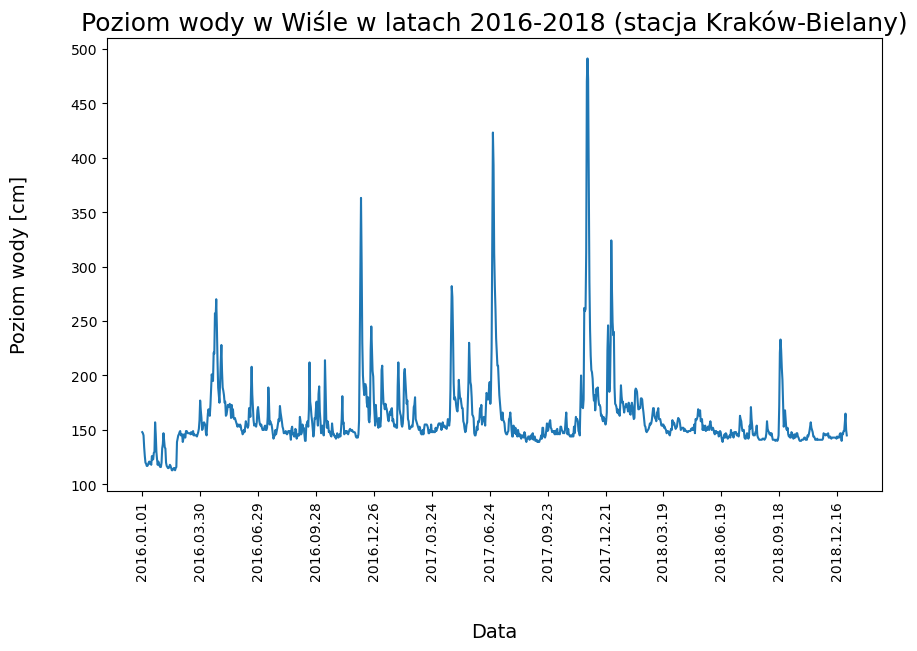

In [8]:
fig1 = plt.figure(figsize=(10, 6), dpi=300, facecolor='#ffffff')
plt.errorbar(
    x=KRK_BIELANY['Data'],
    y=KRK_BIELANY['Stan wody [cm]'],
    fmt='-'
)
plt.title('Poziom wody w Wiśle w latach 2016-2018 (stacja Kraków-Bielany)', fontdict={'fontsize':18})
plt.ylabel('Poziom wody [cm]', fontdict={'fontsize':14}, labelpad=30)
plt.xlabel('Data', fontdict={'fontsize':14}, labelpad=30)
plt.xticks(KRK_BIELANY['Data'][::90], rotation=90)
plt.savefig('output/fig1.png')
plt.show()
plt.close(fig1)